**Assignment 3 : Multilayer Perceptron (MLP) Implementation using TensorFlow**.     
**Author : Snehal Utage.**  
ZID : Z1888637

In [84]:
#GENERATE THE DATASET

#Import the required libraries
import numpy as np
import pandas as pd

#For plotting the features and decision boundary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
import warnings
warnings.filterwarnings("ignore") 
#For TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import make_blobs

num_observations = 10000

x1 = np.random.multivariate_normal([0,0],[[0.1,0.2],[0.2,0.1]],num_observations)
x2 = np.random.multivariate_normal([3,3],[[0.1,0.2],[0.2,0.1]],num_observations)
x3 = np.random.multivariate_normal([3,0],[[0.1,0.2],[0.2,0.1]],num_observations)
x4 = np.random.multivariate_normal([0,3],[[0.1,0.2],[0.2,0.1]],num_observations)

features= np.vstack((x1,x2,x3,x4)).astype(np.float32)
labels = np.hstack((np.full(num_observations,0),
                    np.full(num_observations,1),
                    np.full(num_observations,2),
                    np.full(num_observations,3)))
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.33,random_state=42)
print(y_train.shape,y_test.shape)

(26800,) (13200,)


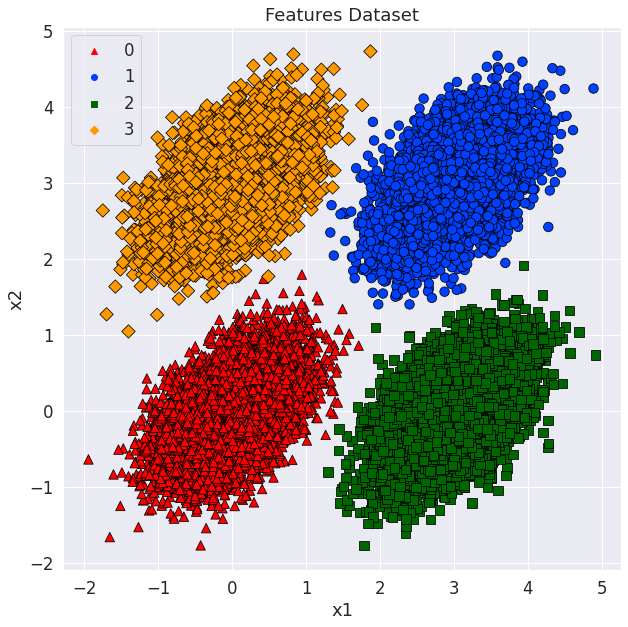

In [85]:
#VISUALISE THE ENTIRE DATASET

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
plt.title("Features Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plot=sns.scatterplot(x=features[:,0], y=features[:,1], hue=labels, s=90 ,style=labels,palette =["#ff0000","#0040ff","#006600","#ff9900"],markers=["^","o","s","D"],edgecolor="black")


In [86]:
#BUILD MLP MODEL

#Build a Sequential model using Keras
#Return a Keras model

#2 Hidden Layers model
#Parameters passed - number of hidden units in Layer 1, HU in Layer 2, Number of class labels, Regularization value
#Activation Function - ReLU, Output Activation function - Softmax
def build_model(unit1,unit2,classes,dropout_val):
  model = keras.Sequential([layers.Dense(unit1,activation="relu",name="layer1"),
                            layers.Dense(unit2,activation="relu",name="layer2"),
                            layers.Dropout(dropout_val),
                            layers.Dense(classes,activation="softmax",name="output")])
  return model

In [87]:
#TRAIN MLP MODEL

#Train the model using TensorFlow and Gradient Tape
#Input - Keras model, Training samples, Training labels
def train_model(modelname,X,y):

  #Track the gradient (forward propagation)
  with tf.GradientTape() as tape:

    #predict using model - returns a onehot format output(4 values(for classes))
    pred=modelname(X)

    #calculate the loss using sparse_categorical_crossentropy as the number of class labels are more than 2
    loss=keras.losses.sparse_categorical_crossentropy(y,pred)

  #Calculate the gradient using the tape 
  grads = tape.gradient(loss,modelname.trainable_variables)

  #Update the model weights i.e trainiable_variables
  opt.apply_gradients(zip(grads,modelname.trainable_variables))

In [88]:
#TRAINING WITH HYPERPARAMETERS SET

#Call the respective functions to Build a Keras Model and Train the model

#Set the hyperparameters - number of iterations and leraning rate,Hidden Units, Regularization parameters
epochs=25
lr=0.01

#Initialise Optimizer for training model - Used Adam() optimizer
opt=keras.optimizers.Adam(learning_rate=lr)

#Create different models with different hidden units and regularization parameter
#Model1
model1_HU1=20
model1_HU2=50
dropout1_val=0.3

#Model2
model2_HU1=50
model2_HU2=60
dropout2_val=0.4

#Model3
model3_HU1=100
model3_HU2=100
dropout3_val=0.5

#Model4
model4_HU1=200
model4_HU2=500
dropout4_val=0.6

#Build the respective models - call build_model, number of class labels - 4
model1 = build_model(model1_HU1,model1_HU2,4,dropout1_val)
model2 = build_model(model2_HU1,model2_HU2,4,dropout2_val)
model3 = build_model(model3_HU1,model3_HU2,4,dropout3_val)
model4 = build_model(model4_HU1,model4_HU2,4,dropout4_val)

#Loop over the number of epochs and train each of the models
for epoch in range(epochs):
  #Train the models using TF and GradientTape
  train_model(model1,X_train,y_train)
  train_model(model2,X_train,y_train)
  train_model(model3,X_train,y_train)
  train_model(model4,X_train,y_train)


In [89]:
#PLOT THE DECISION BOUNDARY 

#Used to predict the class labels from the model
#For keras the output is onehot encoded(4 values and need to get the class from these values) 
#We find the class label which has the maximum value and return that label
#Required for the plotting the decision boundary
#Input - Keras model
class Onehot2Int(object):
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        y_pred = self.model.predict(X)
        return np.argmax(y_pred, axis=1)

#Plot the decision boundary using mlxtend - plot_decision_regions for respective models
def plot_decision_boundary(modelname,features,labels,HU,dropout,name):
  classifier_model = Onehot2Int(modelname)
  plt.figure(figsize=(10,10))
  plt.title("Decision boundary for {0} HU - {1} Dropout - {2}".format(name,HU,dropout))
  plt.xlabel("x1")
  plt.ylabel("x2")
  plot = plot_decision_regions(features, labels, clf=classifier_model, markers=["^","o","s","D"], colors='#ff0000,#0040ff,#006600,#ff9900')
  plt.show()

In [90]:
#ACCURACY AND LOSS CALCULATIONS

#To calculate the accuracy and loss 
#Returns Loss and Accuracy
def calc_accuracy(modelname,features,labels):
  #compile the keras model 
  modelname.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy,metrics=["acc"])

  #compute accuracy and loss using evaluate for testing data
  loss,accuracy = modelname.evaluate(features, labels)
  return loss,accuracy

In [91]:
#ANALYSIS OF MODELS - Training & Testing Accuracy, Decision Boundary for models
#Find the Accuracy and Loss for test and train data
#Plot the decision boundary for respective model

def model_analysis(modelname,training_data,training_labels,test_data,test_labels,total_HU,dropout_val,model_str):
  print("######################################\n#  Summary of Trained MLP - {}  #\n######################################\n".format(model_str))

  print("############################################\n#    {0}  HU : {1}  Dropout : {2}       #\n############################################\n".format(model_str,total_HU,dropout_val))
  test_loss,test_accuracy = calc_accuracy(modelname,test_data,test_labels)
  print("Loss : {:.4f}".format(test_loss))
  print("Test accuracy: {:.2f} %\n".format(test_accuracy*100))

  training_loss,training_accuracy = calc_accuracy(modelname,training_data,training_labels)
  print("Loss : {:.4f}".format(training_loss))
  print("Training accuracy: {:.2f} %".format(training_accuracy*100))
 
  print("\nPlotting Decision Boundary classifying into different classes : TESTING DATA")
  plot_decision_boundary(modelname,test_data,test_labels,total_HU,dropout_val,model_str)

  print("\nPlotting Decision Boundary classifying into different classes : TRAINING DATA")
  plot_decision_boundary(modelname,training_data,training_labels,total_HU,dropout_val,model_str)

######################################
#  Summary of Trained MLP - Model 1  #
######################################

############################################
#    Model 1  HU : 70  Dropout : 0.3       #
############################################

413/413 [==============================] - 0s 904us/step - loss: 0.0103 - acc: 0.9986
Loss : 0.0103
Test accuracy: 99.86 %

838/838 [==============================] - 1s 838us/step - loss: 0.0102 - acc: 0.9984
Loss : 0.0102
Training accuracy: 99.84 %

Plotting Decision Boundary classifying into different classes : TESTING DATA


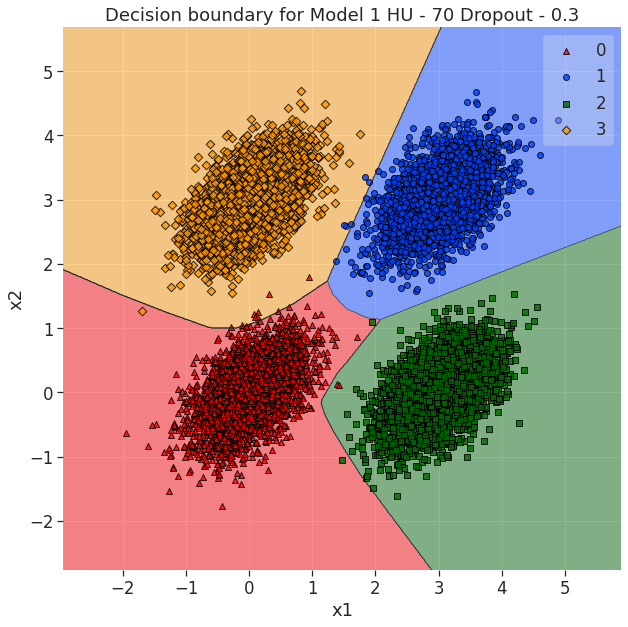


Plotting Decision Boundary classifying into different classes : TRAINING DATA


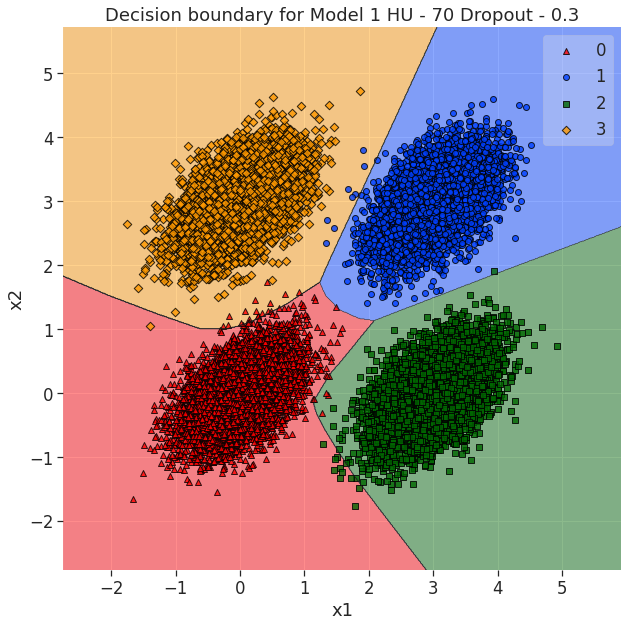

In [92]:
#Model 1 Analysis summary - For Testing and training data

#Call the model_analysis function to get the accuracy and decision boundary for test and training data
model_analysis(model1,X_train,y_train,X_test,y_test,model1_HU1+model1_HU2,dropout1_val,"Model 1")

######################################
#  Summary of Trained MLP - Model 2  #
######################################

############################################
#    Model 2  HU : 110  Dropout : 0.4       #
############################################

413/413 [==============================] - 0s 847us/step - loss: 0.0029 - acc: 0.9995
Loss : 0.0029
Test accuracy: 99.95 %

838/838 [==============================] - 1s 863us/step - loss: 0.0034 - acc: 0.9993
Loss : 0.0034
Training accuracy: 99.93 %

Plotting Decision Boundary classifying into different classes : TESTING DATA


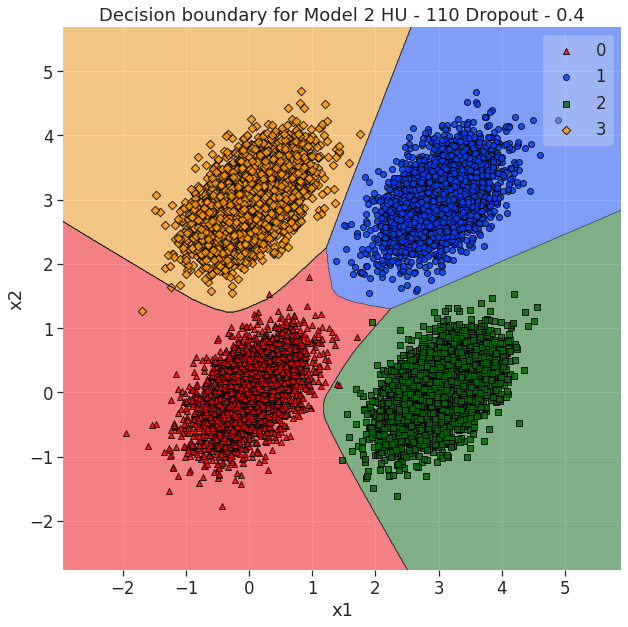


Plotting Decision Boundary classifying into different classes : TRAINING DATA


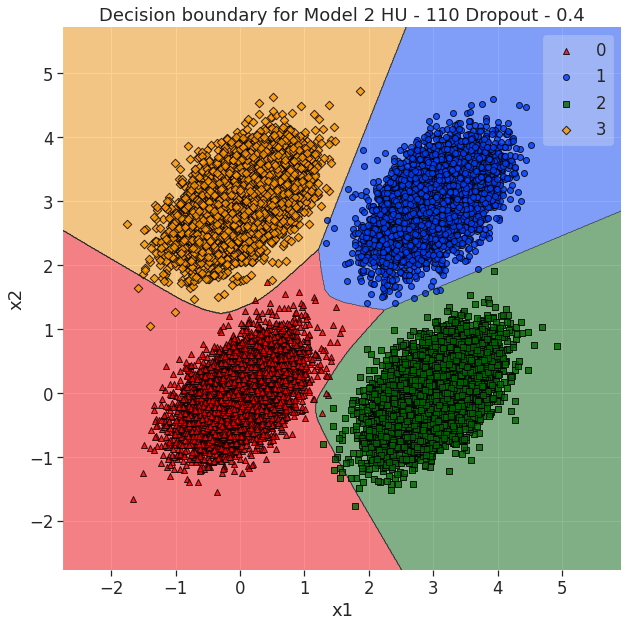

In [93]:
#Model 2 Analysis summary - For Testing and training data

#Call the model_analysis function to get the accuracy and decision boundary for test and training data
model_analysis(model2,X_train,y_train,X_test,y_test,model2_HU1+model2_HU2,dropout2_val,"Model 2")

######################################
#  Summary of Trained MLP - Model 3  #
######################################

############################################
#    Model 3  HU : 200  Dropout : 0.5       #
############################################

413/413 [==============================] - 0s 838us/step - loss: 0.0022 - acc: 0.9995
Loss : 0.0022
Test accuracy: 99.95 %

838/838 [==============================] - 1s 864us/step - loss: 0.0024 - acc: 0.9994
Loss : 0.0024
Training accuracy: 99.94 %

Plotting Decision Boundary classifying into different classes : TESTING DATA


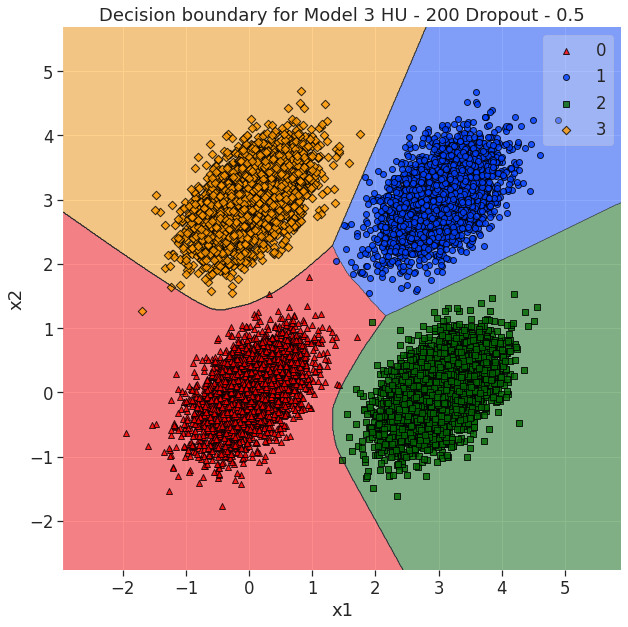


Plotting Decision Boundary classifying into different classes : TRAINING DATA


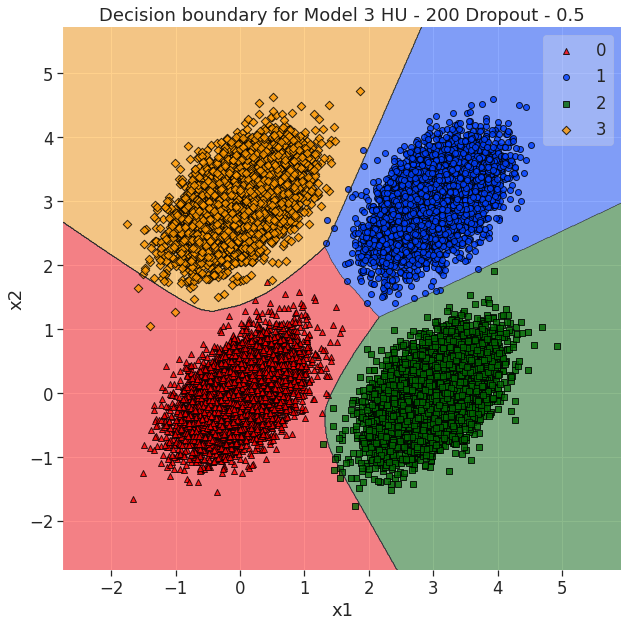

In [94]:
#Model 3 Analysis summary - For Testing and training data

#Call the model_analysis function to get the accuracy and decision boundary for test and training data
model_analysis(model3,X_train,y_train,X_test,y_test,model3_HU1+model3_HU2,dropout3_val,"Model 3")

######################################
#  Summary of Trained MLP - Model 4  #
######################################

############################################
#    Model 4  HU : 700  Dropout : 0.6       #
############################################

413/413 [==============================] - 1s 1ms/step - loss: 0.0021 - acc: 0.9996
Loss : 0.0021
Test accuracy: 99.96 %

838/838 [==============================] - 1s 1ms/step - loss: 0.0019 - acc: 0.9996
Loss : 0.0019
Training accuracy: 99.96 %

Plotting Decision Boundary classifying into different classes : TESTING DATA


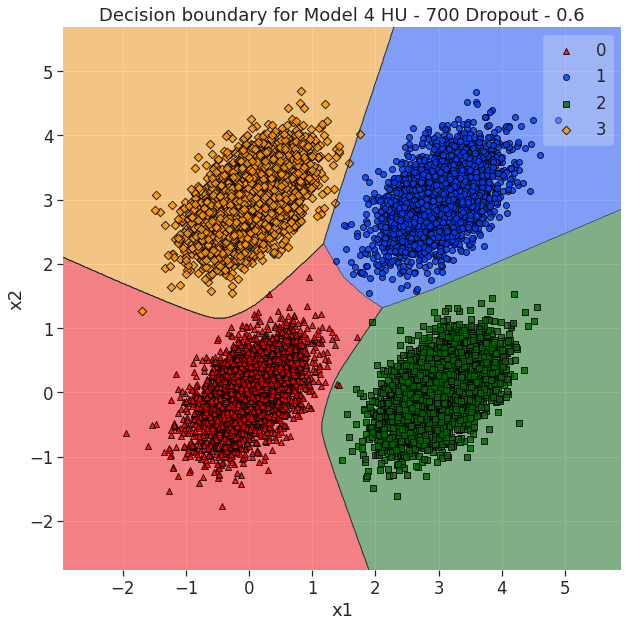


Plotting Decision Boundary classifying into different classes : TRAINING DATA


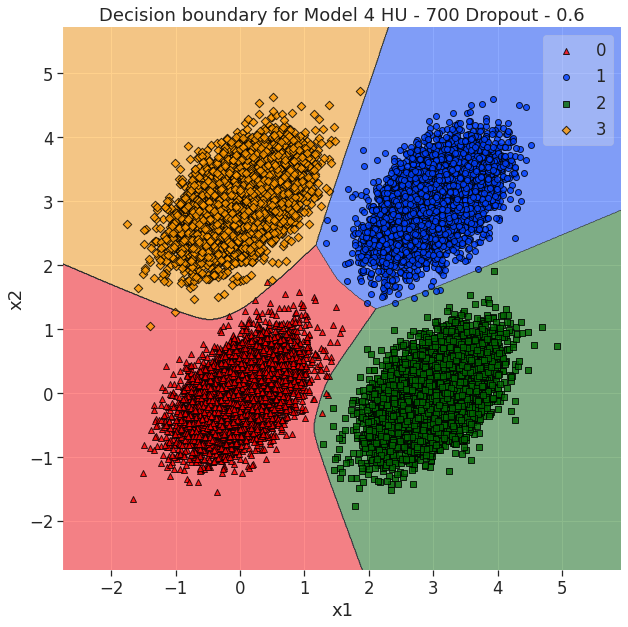

In [95]:
#Model 4 Analysis summary - - For Testing and training data

#Call the model_analysis function to get the accuracy and decision boundary for test and training data
model_analysis(model4,X_train,y_train,X_test,y_test,model4_HU1+model4_HU2,dropout4_val,"Model 4")

#########################################
#  Tested MLP Model for Entire dataset  #
#########################################

1250/1250 [==============================] - 1s 842us/step - loss: 0.0102 - acc: 0.9984
Loss for Model 1: 0.0102
Test accuracy for Model 1 : 99.84 %


Plotting Decision Boundary classifying into different classes : ENTIRE DATASET


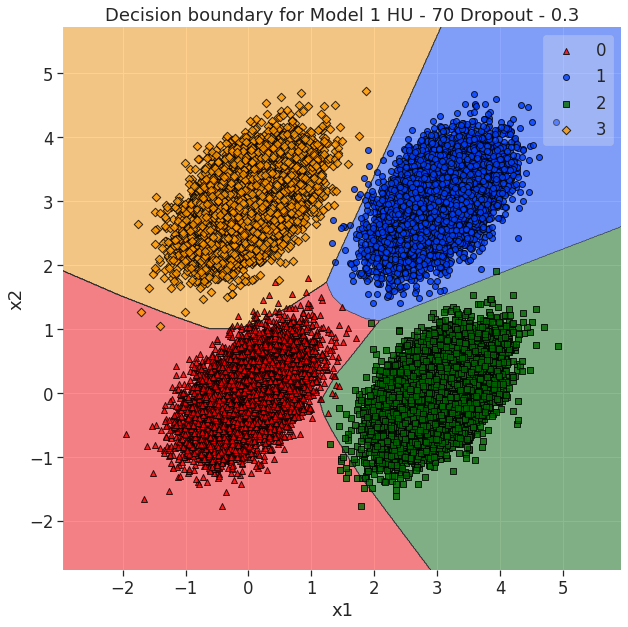

1250/1250 [==============================] - 1s 854us/step - loss: 0.0032 - acc: 0.9994
Loss for Model 2: 0.0032
Test accuracy for Model 2: 99.94 %



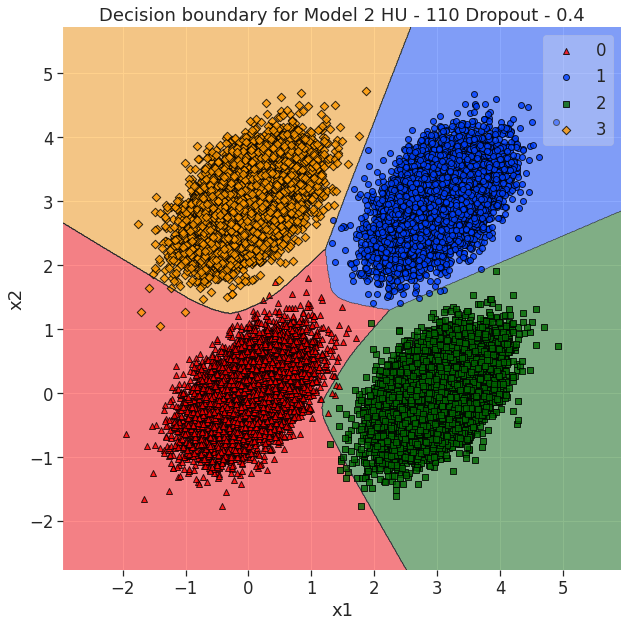

1250/1250 [==============================] - 1s 842us/step - loss: 0.0024 - acc: 0.9995
Loss for Model 3: 0.0024
Test accuracy for Model 3: 99.95 %



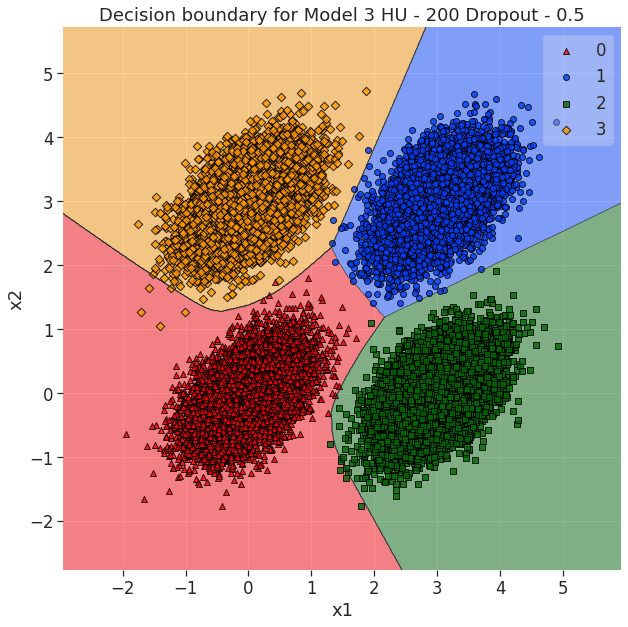

1250/1250 [==============================] - 1s 1ms/step - loss: 0.0019 - acc: 0.9996
Loss for Model 4: 0.0019
Test accuracy for Model 4: 99.96 %



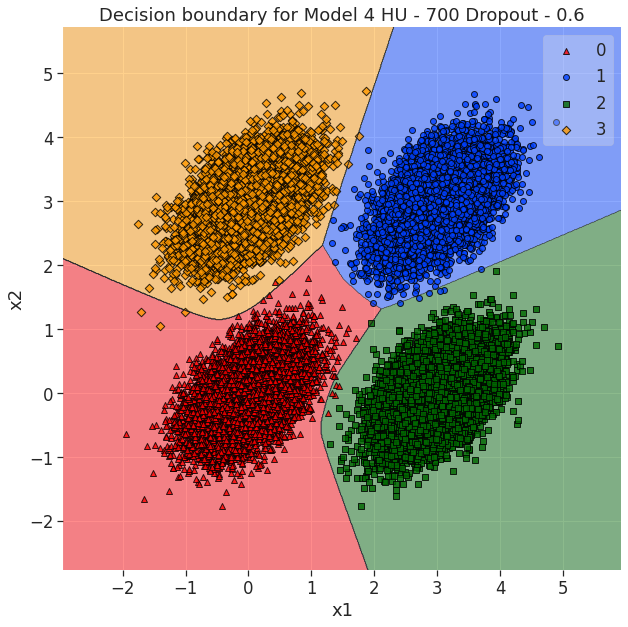

In [96]:
#ENTIRE DATASET SUMMARY FOR EACH MODEL - 
#Impact of changing HU and Dropout
#We can see how the decision boundary becomes curved with the regularization
#and accuracy increase with the HU
#Achieched good accuracy and curved boundary in Model - 3,4
#Accuracy and loss for the entire dataset(training + testing) for each model

print("#########################################\n#  Tested MLP Model for Entire dataset  #\n#########################################\n")
loss,accuracy = calc_accuracy(model1,features,labels)
print("Loss for Model 1: {:.4f}".format(loss))
print("Test accuracy for Model 1 : {:.2f} %\n".format(accuracy*100))
print("\nPlotting Decision Boundary classifying into different classes : ENTIRE DATASET")
plot_decision_boundary(model1,features,labels,model1_HU1+model1_HU2,dropout1_val,"Model 1")

loss,accuracy = calc_accuracy(model2,features,labels)
print("Loss for Model 2: {:.4f}".format(loss))
print("Test accuracy for Model 2: {:.2f} %\n".format(accuracy*100))
plot_decision_boundary(model2,features,labels,model2_HU1+model2_HU2,dropout2_val,"Model 2")

loss,accuracy = calc_accuracy(model3,features,labels)
print("Loss for Model 3: {:.4f}".format(loss))
print("Test accuracy for Model 3: {:.2f} %\n".format(accuracy*100))
plot_decision_boundary(model3,features,labels,model3_HU1+model3_HU2,dropout3_val,"Model 3")

loss,accuracy = calc_accuracy(model4,features,labels)
print("Loss for Model 4: {:.4f}".format(loss))
print("Test accuracy for Model 4: {:.2f} %\n".format(accuracy*100))
plot_decision_boundary(model4,features,labels,model4_HU1+model4_HU2,dropout4_val,"Model 4")